# Classification Analysis
This notebook will contain classification analysis for both the sensed and pipelined algorithms. Analysis will be preformed in regards for the sensed and pipelined algorthms themselves, as well as the ensemble algorithms. The analysis for the ensemble algorithm will focus on the HAMF android phones and the HAHF iOS phones.

## Dependencies

In [341]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [342]:
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev
import emeval.viz.geojson as ezgj

In [343]:
# for analysized view
import emeval.analysed.phone_view as eapv
from emeval.analysed.location_smoothing import add_dist, calDistance

In [344]:
import emeval.metrics.segmentation as ems

In [345]:
# Metrics helpers
import emeval.metrics.dist_calculations as emd
import emeval.metrics.reference_trajectory as emr

In [346]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import arrow

In [347]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.integrate

In [348]:
# For plots
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [349]:
# For maps
import geopandas as gpd
import shapely as shp
import folium
import branca.element as bre

In [350]:
# For easier debugging while working on modules
import importlib

In [351]:
import arrow

## Load in Phone Views from the file spec

In [352]:
DATASTORE_LOC = "bin/data"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd_la = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")
sd_sj = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "car_scooter_brex_san_jose")
sd_ucb = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

After iterating over 1 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00


In [353]:
%%capture
pv_la = eipv.PhoneView(sd_la)
# pv_sj = eipv.PhoneView(sd_sj)
# pv_ucb = eipv.PhoneView(sd_ucb)

### Get sensed data for each trip

In [354]:
FILE_MAPPING = {
    pv_la: "unimodal_trip_car_bike_mtv_la",
    # pv_sj: "car_scooter_brex_san_jose",
    # pv_ucb: "train_bus_ebike_mtv_ucb"
}

In [355]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
# ems.fill_sensed_section_ranges(pv_sj)
# ems.fill_sensed_section_ranges(pv_ucb)

## Get sensed and ground truth temporal histories (timelines)

In [356]:
from pathlib import Path

def get_gt_location_data(trip_id: str, section_id: str):

    root = Path("./bin/data")
    return_file = None

    workdir = root
    if (workdir / trip_id).exists():
        workdir = workdir / trip_id
        assert workdir.is_dir(), f"{trip_id} is a file, not a dir."
        if (workdir / section_id).exists():
            workdir = workdir / section_id
            assert workdir.is_dir(), f"{trip_id}.{section_id} is a file, not a dir."
            files = [f for f in workdir.iterdir()]
            assert files is not None and len(files) > 0, f"No files found for {trip_id=} and {section_id=}"

            # sort the files by run number (just in case).
            files = list(sorted(files, key=lambda x: int(x.name.split("_")[-1])))

            # Concatenate all the trips into a single consolidated df but add an extra column that allows you
            # to filter on the run number (if required).
            df = pd.read_csv(files[0])
            df['run'] = '0'

            for ix, run_file in enumerate(files[1:]):
                tdf = pd.read_csv(run_file)
                tdf['run'] = str(ix+1)
                df = pd.concat([df, tdf], axis=0)
            
            return_file = df.reset_index(drop=True, inplace=False)
    
    return return_file

In [357]:
# x = get_gt_location_data('unimodal_trip_car_bike_mtv_la', 'suburb_bicycling')

In [358]:
# display(x.head())

In [369]:
def get_trip_ss_and_gts_timeline(pv, os, role):
    assert os in ['android', 'ios'], 'UNKNOWN OS'
    assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
    trips = []
    for phone_os, phone_map in pv.map().items():
        if os != phone_os:
            continue
        for phone_label, phone_detail_map in phone_map.items():
            if "control" in phone_detail_map["role"]:
                continue
            for r in phone_detail_map["evaluation_ranges"]:
                if r['eval_role_base'] != role:
                    continue
                tr_ss  = []
                tr_gts = []
                gt_dfs = []
                
                for i, tr in enumerate(r["evaluation_trip_ranges"]):
                    for ss in tr["sensed_section_ranges"]:
                        tr_ss.append(ss)
                    for section in tr["evaluation_section_ranges"]:
                        ## get the ground truth section data
                        section_gt_leg = pv.spec_details.get_ground_truth_for_leg(tr['trip_id_base'],
                                                                                  section['trip_id_base'],
                                                                                  tr['start_ts'],
                                                                                  tr['end_ts'])
                        
                        if section_gt_leg["type"] == "WAITING":
                            continue
                        
                        gts = {'start_ts': section['start_ts'], 
                               'end_ts': section['end_ts'], 
                               'mode': section_gt_leg['mode']
                               }

                        tr_gts.append(gts)

                    gt_location_data = get_gt_location_data(FILE_MAPPING[pv], tr['trip_id_base'])
                    run_id = r['trip_run']
                    print(run_id, tr['trip_id'], tr['trip_id'])
                    gt_location_data = gt_location_data.query("source == @os")
                    gt_location_data = gt_location_data.loc[gt_location_data.run == str(run_id), :].reset_index(drop=True, inplace=False)
                    gt_dfs.append(gt_location_data)

                print(5*'-')

                # now, we build a timeline for each trip
                trip = tr.copy()
                trip['ss_timeline']  = tr_ss
                trip['gts_timeline'] = tr_gts
                trip['gt_location_df'] = gt_dfs
                
                trips.append(trip)
    
    return trips

In [374]:
trips = get_trip_ss_and_gts_timeline(pv_la, 'android', 'HAHFDC')

0 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
0 suburb_bicycling_0 suburb_bicycling_0
-----
1 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
1 suburb_bicycling_0 suburb_bicycling_0
-----
2 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
2 suburb_bicycling_0 suburb_bicycling_0
-----
0 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
0 suburb_bicycling_0 suburb_bicycling_0
-----
1 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
1 suburb_bicycling_0 suburb_bicycling_0
-----
2 suburb_city_driving_weekend_0 suburb_city_driving_weekend_0
2 suburb_bicycling_0 suburb_bicycling_0
-----


## Define the Base Mode Maps

#### raw base mode map

In [332]:
RBMM = {
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR",
    "MISALIGNED" : "MISALIGNED", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED", 
    "INVALID" : "UNKNOWN", 
    "UNKNOWN" : "UNKNOWN", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### cleaned base mode map

e-mission-server.emission.core.wrapper.motionactivity.py

In [333]:
CBMM = {
    0 : 'AUTOMOTIVE', 
    1 : 'CYCLING', 
    2 : 'WALKING', 
    3 : 'WALKING', 
    4 : 'UNKNOWN', 
    5 : 'WALKING', 
    7 : 'WALKING', 
    8 : 'WALKING', 
    9 : 'UNKNOWN', 
    10 : 'AUTOMOTIVE', 
    11 : 'AIR_OR_HSR', 
    "WALKING": "WALKING",
    "RUNNING" : "WALKING", 
    "CYCLING" : "CYCLING",
    "BICYCLING": "CYCLING",
    "E_BIKE" : "CYCLING",
    "ESCOOTER": "CYCLING", 
    "AUTOMOTIVE" : "AUTOMOTIVE",
    "BUS": "AUTOMOTIVE",
    "TRAIN": "AUTOMOTIVE",
    "LIGHT_RAIL": "AUTOMOTIVE",
    "SUBWAY": "AUTOMOTIVE",
    "CAR": "AUTOMOTIVE",
    "AIR_OR_HSR": "AIR_OR_HSR", 
    "NO_SENSED" : "MISALIGNED", 
    "NO_GT" : "MISALIGNED",
    "MISALIGNED" : "MISALIGNED", 
    "UNKNOWN" : "UNKNOWN",
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

### inferred base mode maps

e-mission-server.emission.core.wrapper.modeprediction.py

#### random forest base mode map

In [334]:
RFBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'TRAIN',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
         "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### rule+GIS base mode map

In [335]:
GISBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'BUS',        # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'CAR',        # CAR
        6 : 'AIR_OR_HSR', # AIR_OR_HSR
        7 : 'SUBWAY',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
        "E_BIKE" : "CYCLING",
         "ESCOOTER": "CYCLING", 
         "BUS": "BUS",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "CAR",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "UNKNOWN" : "UNKNOWN",
         "NO_SENSED" : "MISALIGNED", 
         "NO_GT" : "MISALIGNED",
         "MISALIGNED" : "MISALIGNED", 
    'NO_SENSED_START' : 'NO_SENSED',
    'NO_SENSED_MIDDLE' : 'NO_SENSED',
    'NO_SENSED_END' : 'NO_SENSED',
    'NO_GT_START' : 'NO_GT',
    'NO_GT_MIDDLE' : 'NO_GT',
    'NO_GT_END' : 'NO_GT'
}

#### Pad the start at end of the timelines for a given trip, while also filling in gaps in the middle

In [336]:
def align_timelines(trip):
    ss_timeline = trip['ss_timeline']
    gt_timeline = trip['gts_timeline']
    ss_aligned_timeline = []
    gt_aligned_timeline = []
    ####### FILL IN SENSED TIMELINE #######
    ### fill in start ###
    if len(ss_timeline) == 0:
        if len(gt_timeline) == 0:
            return ss_timeline, gt_timeline
        else:
            ss_timeline.append(
                {
                    'mode' : 'NO_SENSED_START',
                    'start_ts' : gt_timeline[0]['start_ts'],
                    'end_ts' : gt_timeline[-1]['end_ts']
                }
            )

    if len(gt_timeline) == 0:
        gt_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : ss_timeline[0]['start_ts'],
                'end_ts' : ss_timeline[-1]['end_ts']
            }
        )

    if 'data' in ss_timeline[0]:
        start_misalignment = ss_timeline[0]['data']['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['data']['end_ts'] - gt_timeline[-1]['end_ts']
    else:
        start_misalignment = ss_timeline[0]['start_ts'] - gt_timeline[0]['start_ts']
        end_misalignment = ss_timeline[-1]['end_ts'] - gt_timeline[-1]['end_ts']

    if start_misalignment > 0:
        if 'data' in ss_timeline[0].keys():
            ss_timeline[0] = ss_timeline[0]['data']
        
        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_START',
                'start_ts' : ss_timeline[0]['start_ts'] - start_misalignment,
                'end_ts' : ss_timeline[0]['start_ts']
            }
        )
    ### fill in meat ###
    for ss in ss_timeline:
        if 'data' in ss.keys():
            ss = ss['data']
        if 'sensed_mode' in ss.keys():
            ss['mode'] = ss['sensed_mode']
        if len(ss_aligned_timeline) > 0:
            ## check to see if there is a gap ##
            if ss['start_ts'] - ss_aligned_timeline[-1]['end_ts'] > 0:
                ## fill in the blank
                ss_aligned_timeline.append(
                    {
                        'mode' : 'NO_SENSED_MIDDLE', 
                        'start_ts' : ss_aligned_timeline[-1]['end_ts'],
                        'end_ts' : ss['start_ts']
                    }
                )
        
        ## the timeline is continuous, and we can fill our section ##
        ss_aligned_timeline.append(ss)
    ### fill in end ###
    if end_misalignment < 0:
        ss = ss_timeline[-1]
        if 'data' in ss.keys():
            ss = ss['data']
        ss_aligned_timeline.append(
            {
                'mode' : 'NO_SENSED_END',
                'start_ts' : ss['end_ts'],
                'end_ts' : ss['end_ts'] - end_misalignment
            }
        )

    ####### FILL IN GT TIMELINE #######
    ### fill in start ###
    if start_misalignment < 0:
        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_START',
                'start_ts' : gt_timeline[0]['start_ts'] + start_misalignment,
                'end_ts' : gt_timeline[0]['start_ts'],
            }
        )
    ### fill in meat ###
    for gts in gt_timeline:
        if len(gt_aligned_timeline) > 0:
            ## fill in the blank ##
            if gts['start_ts'] - gt_aligned_timeline[-1]['end_ts'] > 0:
                gt_aligned_timeline.append(
                    {
                        'mode' : 'NO_GT_MIDDLE',
                        'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                        'end_ts' : gts['start_ts']
                    }
                )
        gt_aligned_timeline.append(gts)
    ### fill in end ###
    if end_misalignment > 0:
        gt_aligned_timeline.append(
            {
                'mode' : 'NO_GT_END',
                'start_ts' : gt_aligned_timeline[-1]['end_ts'],
                'end_ts' : gt_aligned_timeline[-1]['end_ts'] + end_misalignment
            }
        )
    return ss_aligned_timeline, gt_aligned_timeline

#### Get the classification metrics (true/false positive, true/false negative) for each Base Mode for a given trip/set-of-trips

In [253]:
def get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None):
    if not test:
        if type(pv) is not list: pv = [pv]
        trips = []
        for v in pv:
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    TP, FN, FP, TN = {}, {}, {}, {}
    for trip in trips:
        gt_location_df = trip['gt_location_df']
        print(gt_location_df.shape)
        ss_timeline, gt_timeline = align_timelines(trip)
        for mode in set(BASE_MODE.values()):
            for ss in ss_timeline:
                for gts in gt_timeline:
                    if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                        range_start = max(ss['start_ts'], gts['start_ts'])
                        range_end = min(ss['end_ts'], gts['end_ts'])

                        filtered_gt_distance = gt_location_df.loc[
                            (gt_location_df.ts >= range_start) & (gt_location_df.ts <= range_end), :
                        ]

                        if filtered_gt_distance.shape[0] == 0:
                            dist = 0
                        else:
                            dist = add_dist(filtered_gt_distance).distance.sum()
                        
                        if dist > 0:
                            print(f"{range_start=}, {range_end=}")
                            print(f"{gt_location_df.ts.min()=}, {gt_location_df.ts.max()=}")
                            print("Computed distance: ", dist)
                            print(50*'-')

                        # if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                        #     TP[mode] = TP.setdefault(mode, 0) + dur
                        # elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                        #     FP[mode] = FP.setdefault(mode, 0) + dur
                        # elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                        #     FN[mode] = FN.setdefault(mode, 0) + dur
                        # else:
                        #     TN[mode] = TN.setdefault(mode, 0) + dur

                        if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            TP[mode] = TP.setdefault(mode, 0) + dist
                        elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                            FP[mode] = FP.setdefault(mode, 0) + dist
                        elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            FN[mode] = FN.setdefault(mode, 0) + dist
                        else:
                            TN[mode] = TN.setdefault(mode, 0) + dist
                    
    return TP, FP, FN, TN

In [254]:
# get_binary_class_in_sec('android', 'HAHFDC', pv_la, RBMM)

# $F_\beta$ score
$$
F_\beta = \frac {(1 + \beta^2) \cdot \mathrm{true\ positive} }{(1 + \beta^2) \cdot \mathrm{true\ positive} + \beta^2 \cdot \mathrm{false\ negative} + \mathrm{false\ positive}}
$$

In [255]:
def get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None):
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE)
    else:
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE, test=True, test_trip=test_trip)
    F_score = {}
    for mode in set(BASE_MODE.values()):
        numerator   = (1 + beta**2) * TP.setdefault(mode, 0)
        denominator = (1+beta**2) * TP.setdefault(mode, 0) + beta**2*FN.setdefault(mode, 0) + FP.setdefault(mode, 0)
        try:
            F_score[mode] = (numerator)/(denominator)
        except:
            F_score[mode] = np.nan
    # initializing K 
    K = 10
    for key in F_score:

        # rounding to K using round()
        F_score[key] = round(F_score[key], K)
    return F_score

#### Get the support for each base mode in a set of trips, which is the sum of confusion matrix row sums for each mode that maps to a base mode, $M_{bm} = \{ m : b(m) = bm, m \in M \}$ 

In [256]:
def get_support(os, role, pv, BASE_MODE):
    if type(pv) is not list: pv = [pv]
    trips = []
    for v in pv:
        trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    support = {}
    for trip in trips:

        gt_loc_df = trip['gt_location_df']

        ## get gts dur
        gt_dur = 0
        # gt_dist = 0
        for gts in trip['gts_timeline']:
            mode = BASE_MODE[gts['mode']]
            support[mode] = support.setdefault(mode, 0) + gts['end_ts'] - gts['start_ts']
            gt_dur += (gts['end_ts'] - gts['start_ts'])
        ## check if there is a NO_GT mode
        ss_dur = 0
        for ss in trip['ss_timeline']:
            try:
                ss_dur += (ss['end_ts'] - ss['start_ts'])
            except:
                ss_dur += (ss['data']['end_ts'] - ss['data']['start_ts'])
        support['NO_GT'] = support.setdefault('NO_GT', 0) + max(0, ss_dur - gt_dur)
    return support

### Weighted $F_1$ Score

\begin{equation}
    F_1^{avg} = \sum_{i=1}^{|BM|} \left[  \sum_{j=1} ^ {|M_{bm_i}|} \sum_{k = 1}^{|M^{inf}|} cm_{j, k} \right] \cdot F_1^{bm}
\end{equation}

In [257]:
def weighted_f_score(os, role, pv, BASE_MODE):
    support = get_support(os, role, pv, BASE_MODE)
    total_support = sum(support.values())
    F_scores = get_F_score(os, role, pv, BASE_MODE)
    weighted_f_score = sum(
        support[mode]/total_support * F_scores.setdefault(mode, 0) 
        for mode in support.keys()
        if not np.isnan(F_scores.setdefault(mode, 0))
    )
    return weighted_f_score

In [258]:
def plot_f_scores(os):
    fig, ax = plt.subplots(1,3, figsize = (15,5), dpi=300, sharey=True, sharex=True)
    for i, role in enumerate(['HAHFDC', 'HAMFDC', 'MAHFDC']):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f' {role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
    title = f"$F_1$ Scores by Base Mode for Phones Running {os} at Various Configuration Settings"
    plt.suptitle(title, weight='bold', size='x-large')
    fig.savefig(f"images/distance_f_scores_for_{os}",  bbox_inches="tight")

#### Plot $F$ scores for android/ios on select configuration settings

In [259]:
def plot_f_scores_selected():
    fig, ax = plt.subplots(1,2, figsize = (10,3), dpi=300, sharey=True, sharex=True)
    for i, (os, role) in enumerate([['android', 'HAMFDC'], ['ios', 'HAHFDC']]):
        raw   = get_F_score(os, role, [pv_la, pv_sj, pv_ucb], RBMM)
        m_clean = get_F_score(os, role, [mcv_la, mcv_sj, mcv_ucb], CBMM)
        g_clean = get_F_score(os, role, [gcv_la, gcv_sj, gcv_ucb], CBMM)
        rf    = get_F_score(os, role, [rfv_la, rfv_sj, rfv_ucb], RFBMM)
        gis   = get_F_score(os, role, [gisv_la, gisv_sj, gisv_ucb], GISBMM)
        df = pd.DataFrame(
            [raw, m_clean, g_clean, rf, gis], 
            index = ['raw', 'master clean', 'GIS clean', 'random forest', 'GIS'], 
            columns=['WALKING', 'CYCLING', 'AUTOMOTIVE', 'CAR', 'BUS', 'TRAIN', 'SUBWAY']
        )
        
        df.T.plot(style='o', ax=ax[i], title=f'$F_1$ Scores by Base Mode \n{os}:{role} ').legend(loc='lower left')
        ax[i].set_xticks(range(len(df.T)))
        ax[i].set_xticklabels(df.columns, rotation = 80)
#     title = f"$F_1$ Scores by Base Mode for Selected OS Setting Configurations"
#     plt.suptitle(title, weight='bold', size='x-large')
    fig.savefig(f"images/distance_f_scores_selected",  bbox_inches="tight")

## Confusion Matrix
We will now generate confusion matrices based off OS and role, with the acctual modes as the rows, the predicted modes as the columns, and the entries as the base unit for the duration measurement

#### cleaned index map

In [260]:
CIM = {0 : 'IN_VEHICLE', 
       1 : 'BICYCLING', 
       2 : 'ON_FOOT', 
       3 : 'STILL', 
       4 : 'UNKNOWN', 
       5 : 'TILTING', 
       7 : 'WALKING', 
       8 : 'RUNNING', 
       9 : 'NONE', 
       10 : 'STOPPED_WHILE_IN_VEHICLE', 
       11 : 'AIR_OR_HSR'}

#### inferred index map

In [261]:
IIM = {
    0 : 'UNKNOWN', 
    1 : 'WALKING', 
    2 : 'BICYCLING', 
    3 : 'BUS', 
    4 : 'TRAIN', 
    5 : 'CAR', 
    6 : 'AIR_OR_HSR',
    7 : 'SUBWAY',
    8 : 'TRAM',
    9 : 'LIGHT_RAIL'
}

In [262]:
def get_confusion_matrix(os, role, pv, test=False, test_trip=None):
    cm_l = []
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        if type(pv) is not list:
            pv = [pv]
        trips = []
        for v in pv :
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    for trip in trips:
        gt_location_df = trip['gt_location_df']
        ss_timeline, gt_timeline = align_timelines(trip)
        for ss in ss_timeline:
            cm = {}
            for gts in gt_timeline:
                if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                    # dur = min(ss['end_ts'], gts['end_ts']) - max(ss['start_ts'], gts['start_ts'])
                    range_start = max(ss['start_ts'], gts['start_ts'])
                    range_end = min(ss['end_ts'], gts['end_ts'])

                    filtered_gt_distance = gt_location_df.loc[
                        (gt_location_df.ts >= range_start) & (gt_location_df.ts <= range_end), :
                    ]

                    if filtered_gt_distance.shape[0] == 0:
                        dist = 0
                    else:
                        dist = add_dist(filtered_gt_distance).distance.sum()
                        
                    # cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dur
                    cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dist
            
            cm['sensed_mode'] = ss['mode']
            
            cm_l.append(cm)
    return cm_l

In [263]:
sort_dict = {
    'WALKING' : 0,
    'RUNNING' : 1,
    'ON_FOOT' : 2,
    'CYCLING' : 3,
    'BICYCLING' : 4,
    'AUTOMOTIVE' : 5,
    'IN_VEHICLE' : 6,
    'CAR': 7,
    'BUS': 8,
    'SUBWAY' : 9,
    'LIGHT_RAIL' : 10,
    'TRAIN' : 11,
    'AIR_OR_HSR' : 12,
    'INVALID' : 13,
    'UNKNOWN' : 14,
    'NO_SENSED_START' : 15,
    'NO_SENSED_MIDDLE' : 16,
    'NO_SENSED_END' : 17
}
def sort_key(s):
    return sort_dict[s]

In [264]:
def plot_cm(os, pv, d_type, INDEX_MAP=None):
    fig, ax = plt.subplots(1,3, figsize=(22,10), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, 0.0, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    for k, role in enumerate(["HAHFDC", "HAMFDC", "MAHFDC"]):
        if d_type =='raw':
            title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            # fname = f"images/raw_cm_{os}"
            fname = f"images/raw_distance_cm_{os}"
        elif d_type == 'clean':
            title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            # fname = f"images/clean_cm_{os}"
            fname = f"images/clean_distance_cm_{os}"
        elif d_type == 'random_forest' or 'gis':
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
            # fname = f"images/{d_type}_cm_{os}"
            fname = f"images/{d_type}_distance_cm_{os}"
            if d_type == 'random_forest':
                title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os} \n by Calibration Settings"
            else:
                title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
        else:
            assert 0, f'INVALID d_type {d_type}'
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)
#         df = df.div(df.sum(axis=1), axis=0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        ax[k].set_title(role)
    #     plt.colorbar(cm, ax=ax[0])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
#                            or df.transpose().iat[i,j] in df.max()
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
    plt.suptitle(title, weight='bold', size='x-large', y=y)

    plt.savefig(fname=fname,  bbox_inches="tight")

#### plot the confusion matrices at each pipeline output stage on android/ios for select configuration settings

In [265]:
def plot_select_cm(os, role):
    IIM = {0 : 'UNKNOWN', 1 : 'WALKING', 2 : 'BICYCLING', 3 : 'BUS', 4 : 'TRAIN', 5 : 'CAR', 6 : 'AIR_OR_HSR', 7 : 'SUBWAY', 8 : 'TRAM', 9 : 'LIGHT_RAIL'
    }
    CIM = {0 : 'IN_VEHICLE', 1 : 'BICYCLING', 2 : 'ON_FOOT', 3 : 'STILL', 4 : 'UNKNOWN', 5 : 'TILTING', 7 : 'WALKING', 8 : 'RUNNING', 9 : 'NONE', 10 : 'STOPPED_WHILE_IN_VEHICLE', 11 : 'AIR_OR_HSR'}
    fig, ax = plt.subplots(1,5, figsize=(30,8), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, -0.1, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.08, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    title = f"Confusion Matrices for Phones Running {os}:{role}"
    # fname = f"images/selected_cm_{os}"
    fname = f"images/selected_distance_cm_{os}"
    for k, pv in enumerate(
        [[pv_la, pv_sj, pv_ucb], 
         [mcv_la, mcv_sj, mcv_ucb],
         [gcv_la, gcv_sj, gcv_ucb], 
         [rfv_la, rfv_sj, rfv_ucb], 
         [gisv_la, gisv_sj, gisv_ucb]]):
        if k == 0:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum()
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        elif k == 1 or k == 2:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=CIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))

        else:
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=IIM)
            df = pd.DataFrame(df, index=sorted(df.index, key=sort_key))
        df = df.reindex(
            columns=['WALKING', 'BICYCLING', 'E_BIKE', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT_START', 'NO_GT_MIDDLE', 'NO_GT_END']
        ).fillna(0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        # title_map = {0 : f'raw output confusion matrix \n{os}:{role}', 
        #              1 : f'master clean output confusion matrix \n{os}:{role}',
        #              2 : f'GIST clean output confusion matrix \n{os}:{role}', 
        #              3 : f'random forest output confusion matrix \n{os}:{role}', 
        #              4 : f'GIS output confusion matrix \n{os}:{role}'}

        title_map = {0 : f'raw output distance confusion matrix \n{os}:{role}', 
                     1 : f'master clean output distance confusion matrix \n{os}:{role}',
                     2 : f'GIST clean output distance confusion matrix \n{os}:{role}', 
                     3 : f'random forest output distance confusion matrix \n{os}:{role}', 
                     4 : f'GIS output distance confusion matrix \n{os}:{role}'}
        
        ax[k].set_title(title_map[k])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
#     plt.suptitle(title, weight='bold', size='x-large', y=y)

#     plt.savefig(fname=fname,  bbox_inches="tight")

## Analyzed Data

#### cleaned view

In [206]:
import copy

In [207]:
MASTER_DATA_LOC = "bin/data/master_9b70c97"
master_spec = eisd.FileSpecDetails(MASTER_DATA_LOC, AUTHOR_EMAIL)

In [208]:
GIS_DATA_LOC = "bin/data/gis_9b679e3/"
gis_spec = eisd.FileSpecDetails(GIS_DATA_LOC, AUTHOR_EMAIL)

In [209]:
mcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
mcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

In [210]:
%%capture
gcv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
gcv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

#### inferred view random forest

sensed_db

In [211]:
%%capture
rfv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
rfv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

#### inferred view GIS
mobilitynet_db

In [212]:
%%capture
gisv_la   = copy.deepcopy(eapv.create_analysed_view(pv_la, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_sj   = copy.deepcopy(eapv.create_analysed_view(pv_sj, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))
gisv_ucb  = copy.deepcopy(eapv.create_analysed_view(pv_ucb, gis_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section"))

# Results 

#### Raw data

For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='suburb_city_driving_weekend_0', section section['trip_id']='walk_end_0', os='ios', found (524, 8) entries
For trip tr['trip_id']='freeway_driving_weekday_0', section section['trip_id']='walk_end_0', os='ios', found (917, 8) entries
For trip tr['trip_id']='freeway_driving_weekday_0', section section['trip_id']='walk_end_0', o

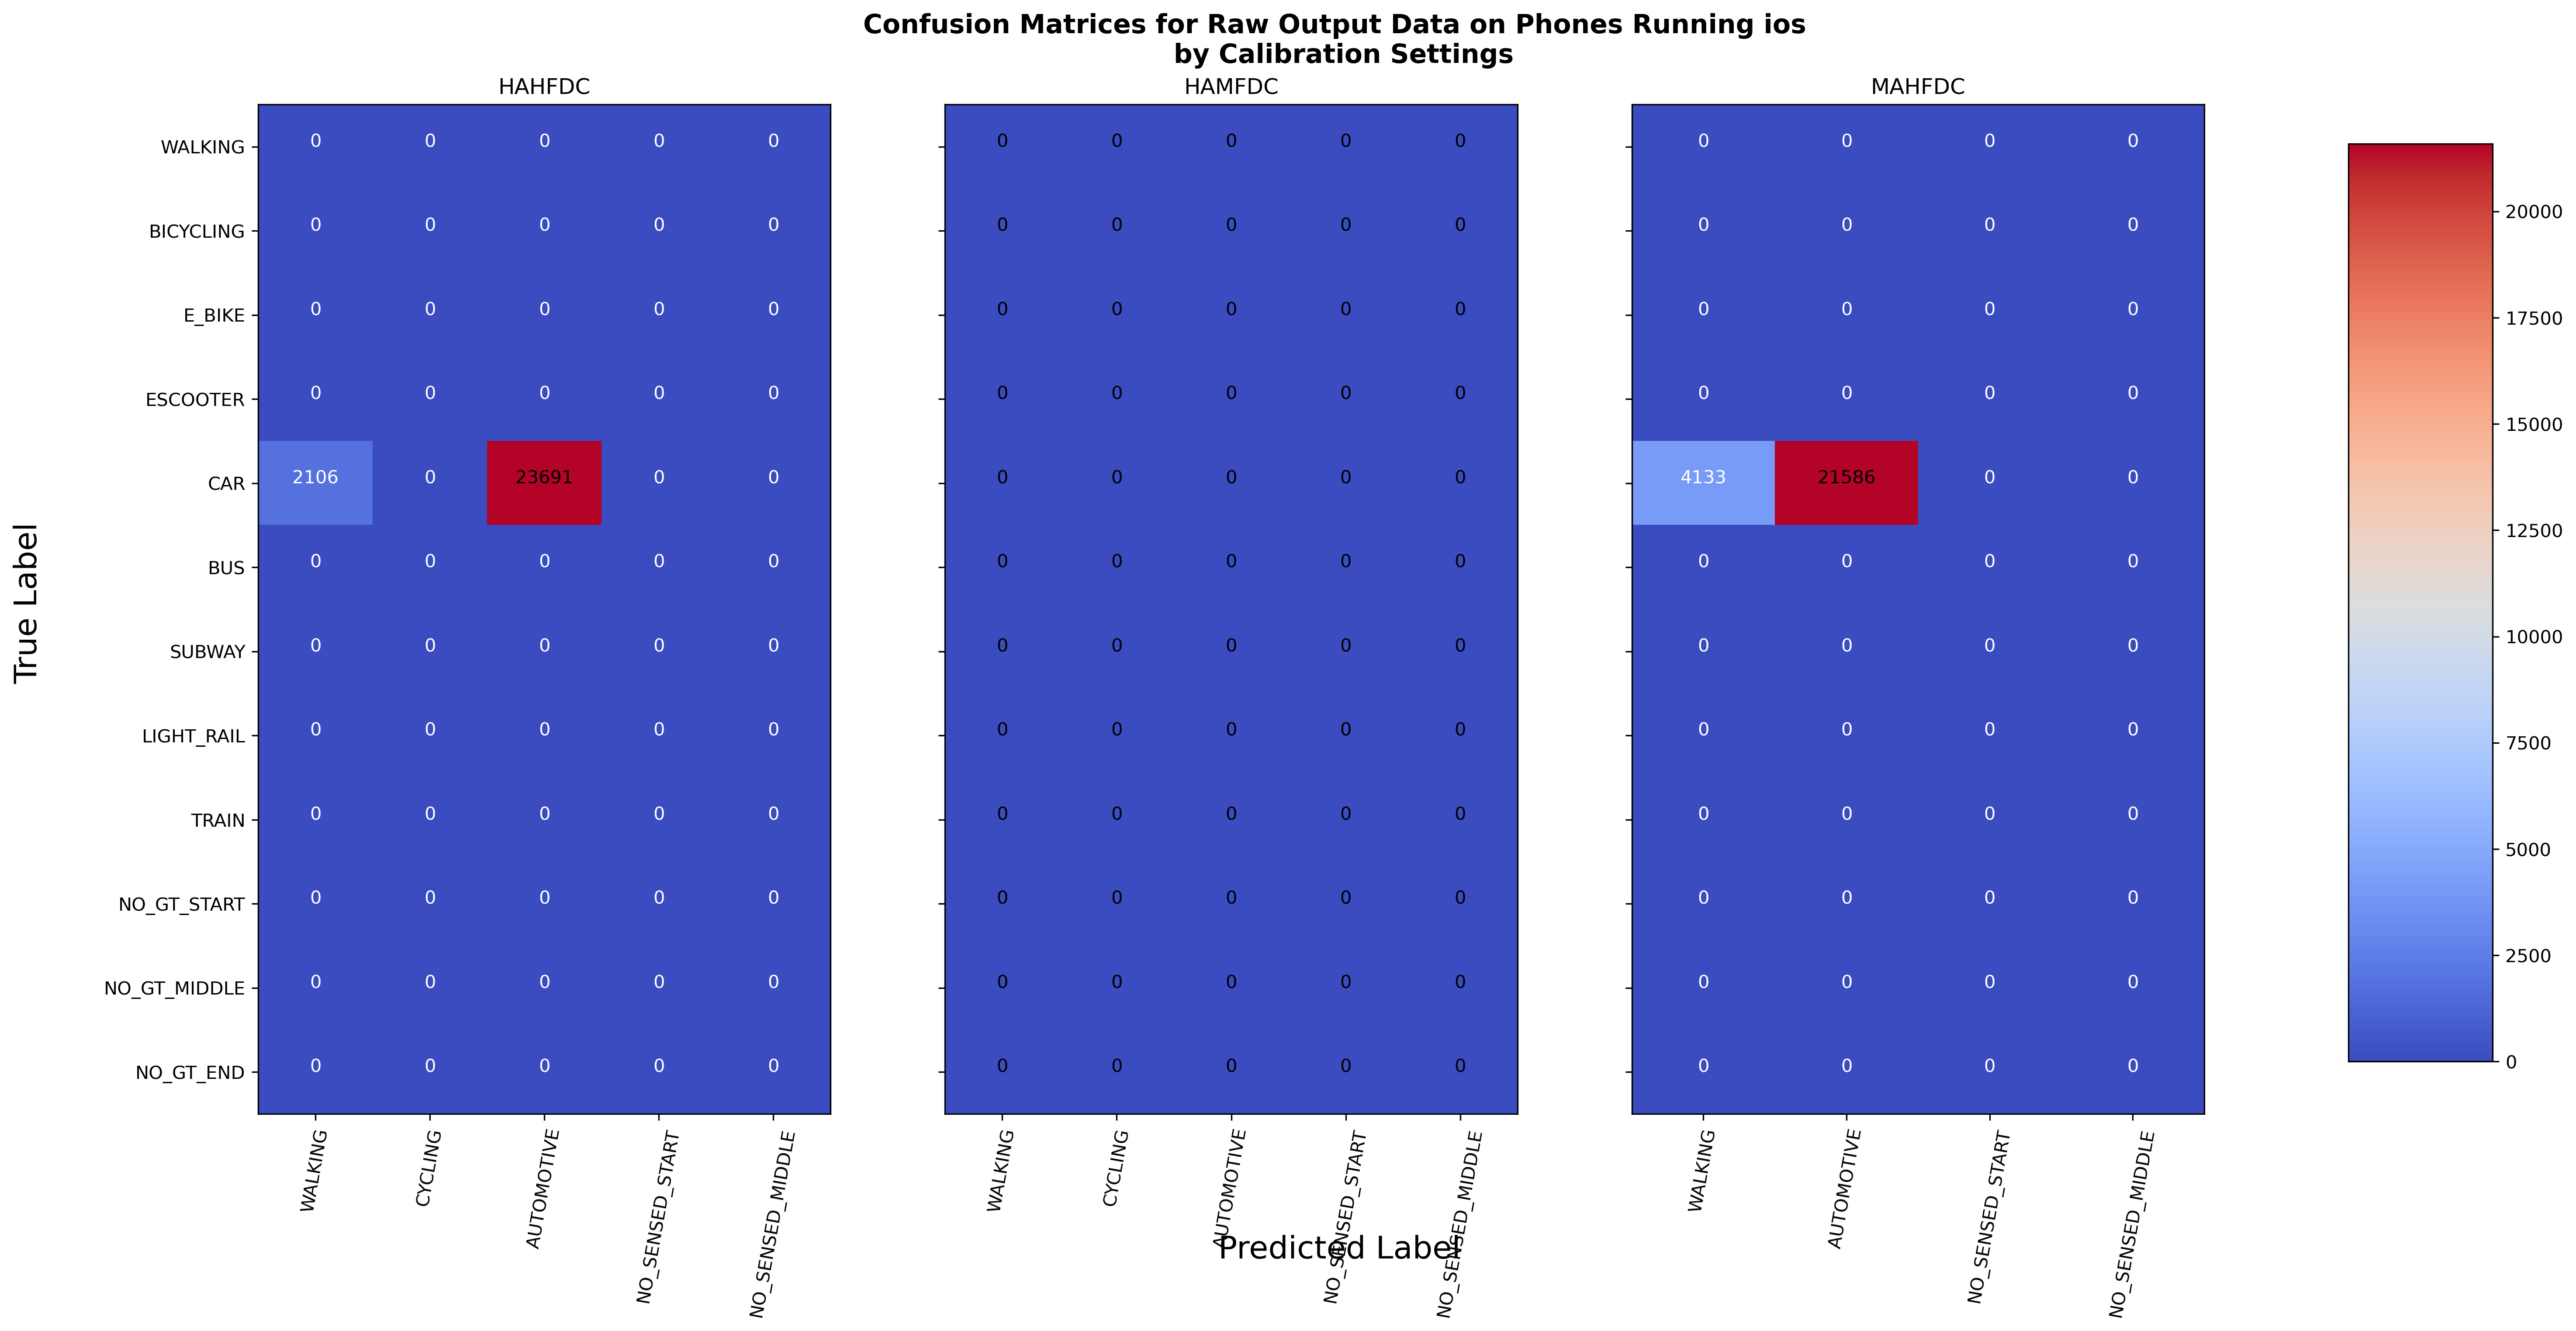

In [266]:
# plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw')
plot_cm('ios', [pv_la, pv_sj], 'raw')

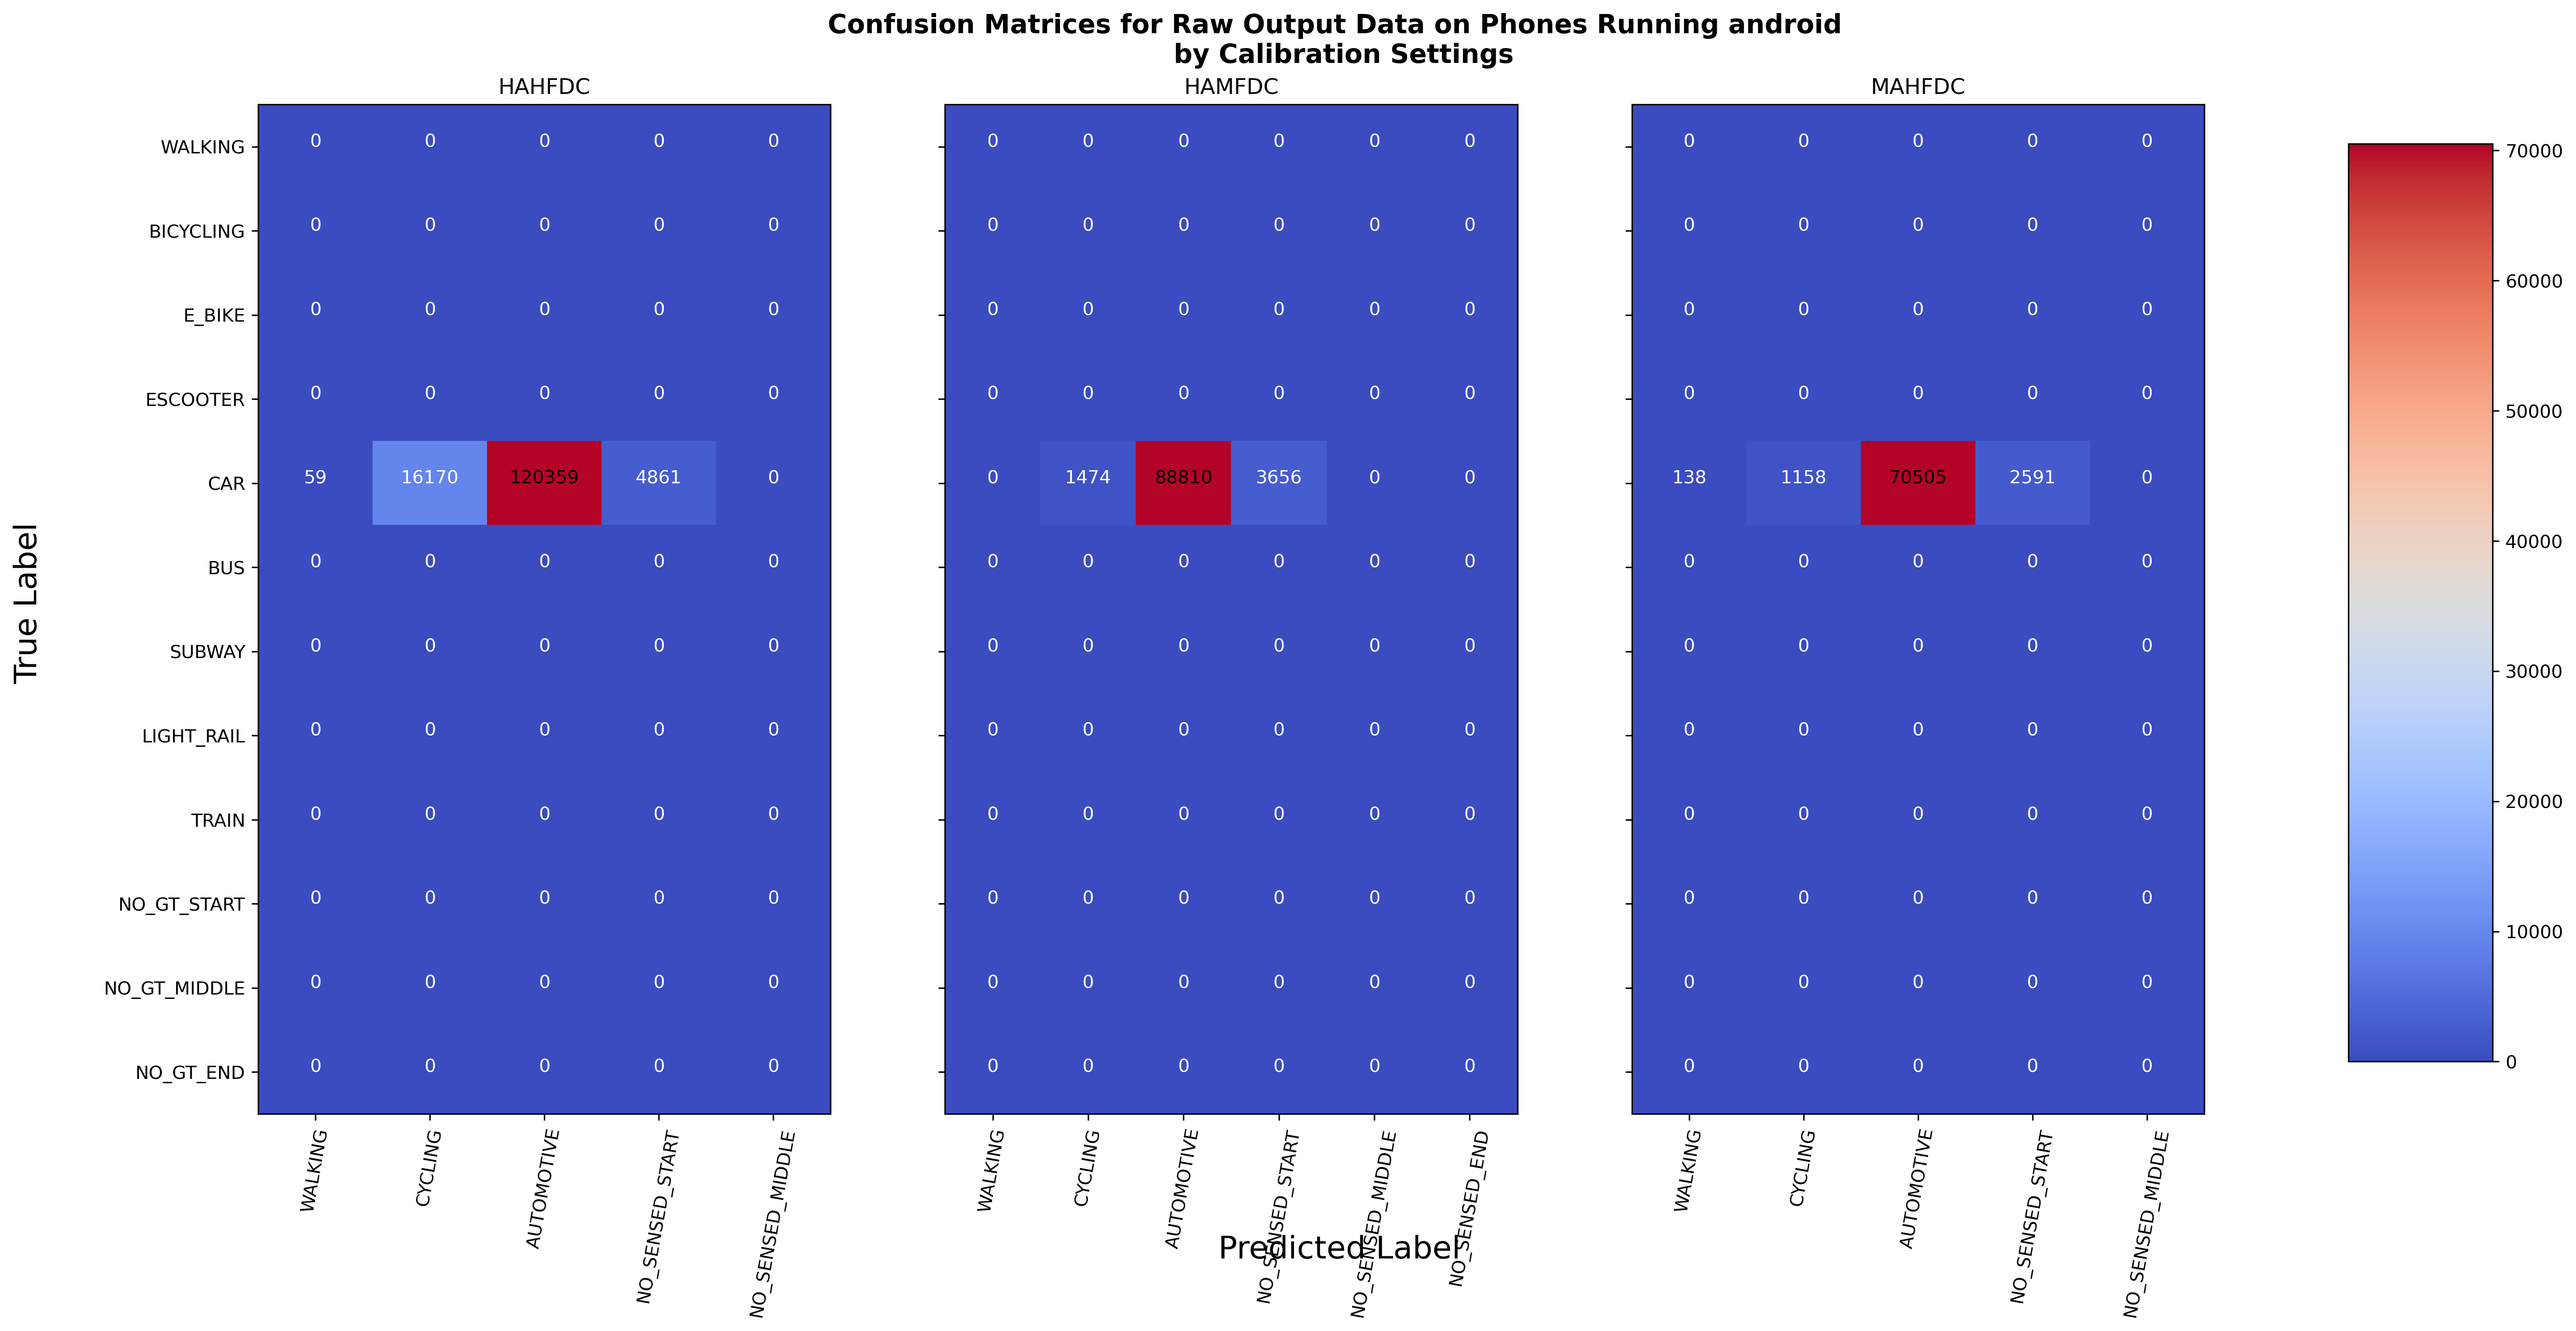

In [219]:
# plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw')
plot_cm('android', [pv_la, pv_sj], 'raw')

#### Cleaned data

In [ ]:
plot_cm('ios', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM)

In [ ]:
plot_cm('android', [mcv_la, mcv_sj, mcv_ucb], 'clean', CIM)

#### Random Forrest

In [ ]:
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

In [ ]:
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

#### GIS

KeyError: <emeval.input.phone_view.PhoneView object at 0x295b55d90>

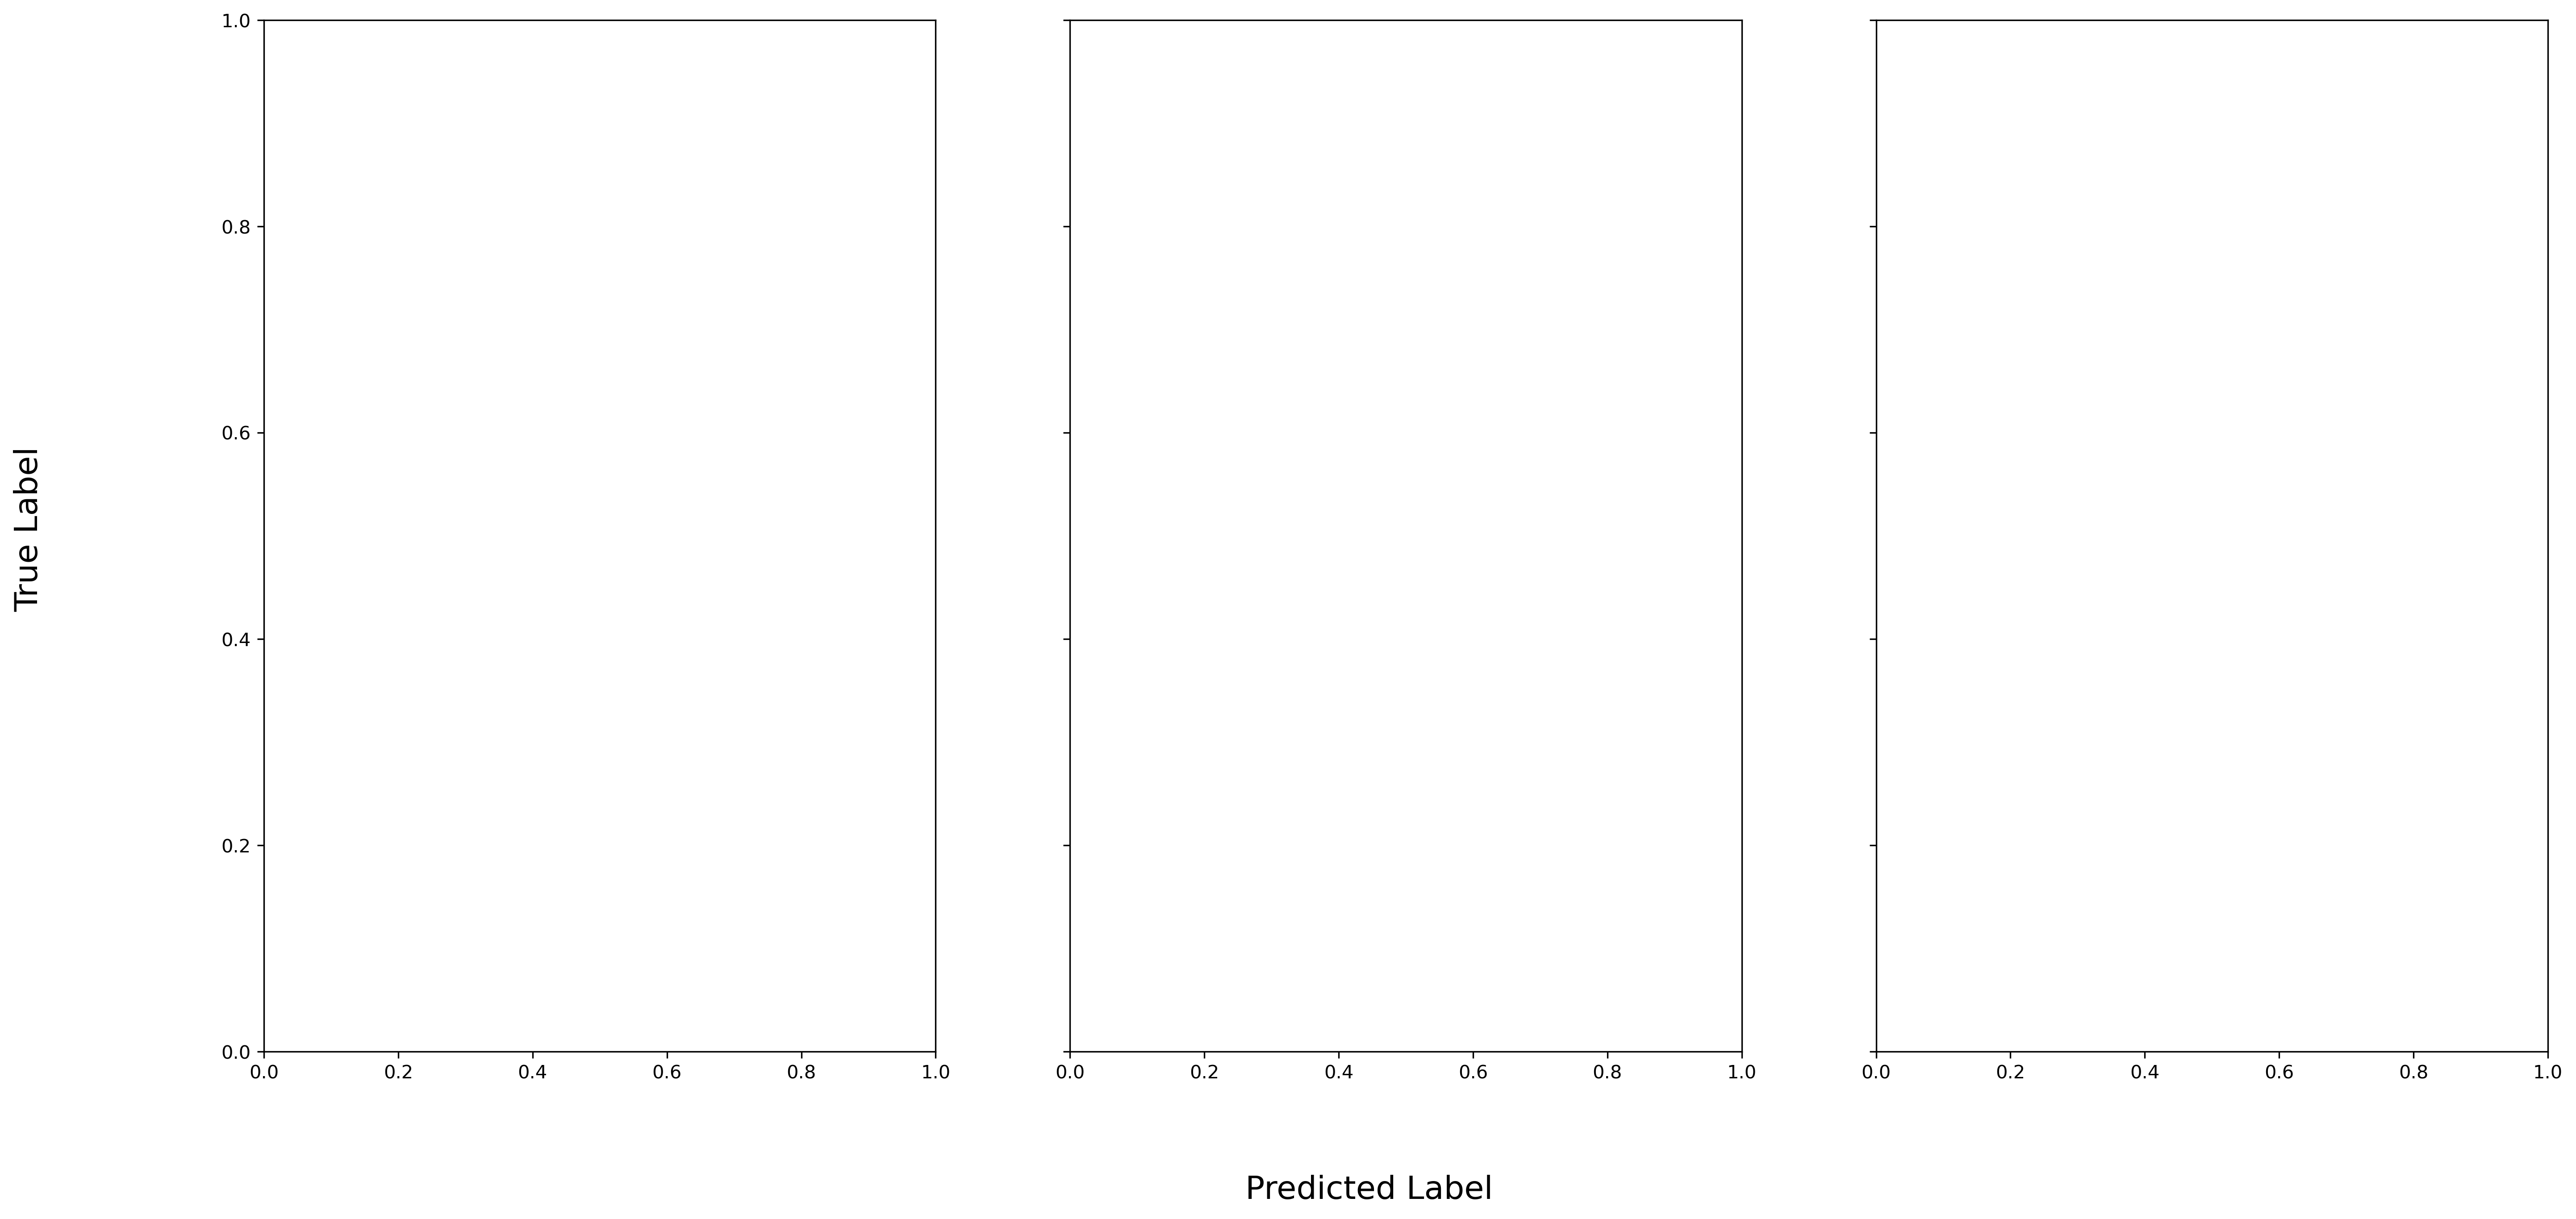

In [220]:
# plot_cm('ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)
plot_cm('ios', [gisv_la,gisv_sj], 'gis', INDEX_MAP=IIM)

In [ ]:
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)

## Combined views

In [ ]:
plot_f_scores('ios')

In [ ]:
plot_f_scores('android')

## Selected Setting

In [ ]:
plot_select_cm('ios', 'HAHFDC')

In [ ]:
plot_select_cm('android', 'HAMFDC')

In [ ]:
plot_f_scores_selected()

In [ ]:
print(
    "GIS android \t",weighted_f_score('android', 'HAMFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM), '\n',
    "GIS ios \t", weighted_f_score('ios', 'HAHFDC', [gisv_la,gisv_sj,gisv_ucb], GISBMM)
)
print(
    "Random Forest android \t",weighted_f_score('android', 'HAMFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM), '\n',
    "Random Forest ios \t",weighted_f_score('ios', 'HAHFDC', [rfv_la,rfv_sj,rfv_ucb], GISBMM)
)

#### get percentage of no sensed predicted mode for a given ground truth mode (in this case ground truth mode = walking)

In [ ]:
for pv_l in [[pv_la, pv_sj, pv_ucb],[mcv_la, mcv_sj, mcv_ucb],[rfv_la,rfv_sj,rfv_ucb],[gisv_la,gisv_sj,gisv_ucb]]:
    df = pd.DataFrame(get_confusion_matrix('android', 'HAMFDC', pv_l)).groupby('sensed_mode').sum().rename(index=IIM)
    w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    print("NO_SENSED trip perdiction for WALKING android:HAMFDC: \t", w_n / df['WALKING'].sum())
    df = pd.DataFrame(get_confusion_matrix('ios', 'HAHFDC', pv_l)).groupby('sensed_mode').sum().rename(index=IIM)
    try:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'] + df['WALKING']['NO_SENSED_END'])
    except:
        w_n = (df['WALKING']['NO_SENSED_START'] + df['WALKING']['NO_SENSED_MIDDLE'])
    print("NO_SENSED trip perdiction for WALKING ios:HAHFDC: \t", w_n / df['WALKING'].sum())

# Unit Testing

* get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None)
* get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None)
* get_confusion_matrix(os, role, pv, test=False, test_trip=None)

## Example timelines

### No sensed at the beggining, No GT at the end, Multimodal


* pipeline timeline

WALKING (0.5, 1.35) -> CYCLING (1.35, 2.7) -> WALKING (2.7, 3.5)

* ground truth timeline

WALKING (0, 1.05) -> BICYCLING (1.05, 3.1)

#### binary classifiers
    + TP 
        + [WALKING: 0.55] 
        + [CYCLING: 1.35]
    + FP 
        + [WALKING: 1.10] 
        + [INVALID: 0.5]
    + FN 
        + [WALKING: 0.50] 
        + [CYCLING: 0.70]
        + [INVALID: 0.4]
    + TN 
        + [WALKING: 1.35] 
        + [CYCLING: 1.45]
        + [INVALID: 2.60]
* $F_1$ score
    + [WALKING: 0.41]
    + [CYCLING: 0.79]
    + [INVALID: ....]
    
#### Confusion Matrix


sensed = [WALKING, CYCLING, NO_SENSED]

ground truth = [WALKING, BICYCLING, NO_GT]

origin top left

    [0.55, 0.00, 0.50]
    [0.70, 1.35, 0.00]
    [0.40, 0.00, 0.00]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.35, 'mode' : 'WALKING'},
                      {'start_ts' : 1.35, 'end_ts' : 2.7, 'mode' : 'CYCLING'}, 
                      {'start_ts' : 2.7, 'end_ts' : 3.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1.05, 'mode' : 'WALKING'}, 
                      {'start_ts' : 1.05, 'end_ts' : 3.1, 'mode' : 'BICYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'BICYCLING' : 'CYCLING', 
            'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID', 
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

#### get_binary_class_in_sec

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert round(res[0]['WALKING'], 2) == 0.55 and round(res[0]['CYCLING'], 2) == 1.35, f"TP wrong"
assert round(res[1]['WALKING'], 2) == 1.10 and round(res[1]['INVALID'], 2) == 0.50 and len(res[1]) == 2, f"FP wrong"
assert round(res[2]['WALKING'], 2) == 0.50 and round(res[2]['CYCLING'], 2) == 0.70 and round(res[2]['INVALID'], 2) == 0.40 and len(res[2]) == 3, f"FN wrong"
assert round(res[3]['WALKING'], 2) == 1.35 and round(res[3]['CYCLING'], 2) == 1.45 and round(res[3]['INVALID'], 2) == 2.60 and len(res[2]) == 3, f"TN wrong"

#### get_F_score

In [ ]:
res = get_F_score(..., ..., ..., test_BMM, beta=1, test=True, test_trip=test_trip)
assert round(res['WALKING'],2) == 0.41 and round(res['CYCLING'], 2) == 0.79 and res['INVALID'] == 0, f"F_1 scores wrong"

#### get_confusion_matrix

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()
assert 'WALKING' in df.index and 'CYCLING' in df.index and 'NO_SENSED_START' in df.index, f"INCORRECT INDECIES \n EXPECTED \t 'WALKING', 'CYCLING', 'NO_SENSED' \n GOT \t \t {df.index}"
assert df.loc['WALKING'].loc['WALKING'] == 0.55 and df.loc['WALKING'].loc['BICYCLING'] == 0.70 and round(df.loc['WALKING'].loc['NO_GT_END'],2) == 0.40
assert df.loc['CYCLING'].loc['WALKING'] == 0 and df.loc['CYCLING'].loc['BICYCLING'] == 1.35 and round(df.loc['CYCLING'].loc['NO_GT_END'],2) == 0.0
assert round(df.loc['NO_SENSED_START'].loc['WALKING'], 2) == 0.50 and df.loc['NO_SENSED_START'].loc['BICYCLING'] == 0.0 and round(df.loc['NO_SENSED_START'].loc['NO_GT_END'],2) == 0.0

### No sensed at beggining and end, multimodal

* pipeline timeline
WALKING (0.5, 1.5)

* ground truth timeline
WALKING (0, 1) -> (1, 2)

#### Multiclass classifiers
* TP
    + WALKING [0.5]
* FP
    + WALKING [0.5]
    + INVALID [1]
* FN
    + WALKING [0.5]
    + CYCLING [1]
* TN
    + WALKING [0.5]
    + CYCLING [1]
    + INVALID [1]
#### Confusion Matrix

sensed mode = ['WALKING', 'NO_SENSED']

ground truth = ['WALKING', 'CYCLING']

    [0.5, 0.5]
    [0.5, 0.5]

In [ ]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1, 'mode' : 'WALKING'}, {'start_ts' : 1, 'end_ts' : 2, 'mode' : 'CYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : "CYCLING", 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 0.5
assert res[1]['INVALID'] == 1.0 and res[1]['WALKING'] == 0.5
assert res[2]['WALKING'] == 0.5 and res[2]['CYCLING'] == 1 
assert res[3]['WALKING'] == 0.5 and res[3]['CYCLING'] == 1 and res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 0.5
assert df.loc['WALKING'].loc['CYCLING'] == 0.5
assert df.loc['NO_SENSED_START'].loc['WALKING'] == 0.5
assert df.loc['NO_SENSED_END'].loc['CYCLING'] == 0.5

### No ground truth at beggining and end, unimodal

* pipeline timeline
WALKING (0, 2)

* ground truth timeline
WALKING (0.5, 1.5)

#### Multiclass classifiers
* TP
    + WALKING [1]
* FP
    + WALKING [1]
* FN
    + INVALID [1]
* TN
    + INVALID [1]
* $F_1$ score
    + ...
#### Confusion Matrix

sensed mode = ['WALKING']

ground truth = ['WALKING', 'NO_GT]

    [1,1]

In [ ]:
test_trip = {
    'gts_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'ss_timeline' : [{'start_ts' : 0, 'end_ts' : 2, 'mode' : 'WALKING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID',
            'NO_SENSED_START' : 'INVALID', 'NO_SENSED_MIDDLE' : 'INVALID', 'NO_SENSED_END' : 'INVALID', 
            'NO_GT_START' : 'INVALID', 'NO_GT_MIDDLE' : 'INVALID', 'NO_GT_END' : 'INVALID'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 1
assert res[1]['WALKING'] == 1
assert res[2]['INVALID'] == 1
assert res[3]['INVALID'] == 1

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

In [ ]:
assert df.loc['WALKING'].loc['WALKING'] == 1
assert df.loc['WALKING'].loc['NO_GT_START'] == 0.5
assert df.loc['WALKING'].loc['NO_GT_END'] == 0.5

## Unimodal Sensed Timeline With Gap

* sensed timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* ground truth timeline
    + WALKING(0, 10)
    
#### Classifiers

* TP
    + WALKING [2]
* FP
    + NO_SENSED [6]
    + CYCLING [2]
* FN
    + WALKING [8]
* TN
    + INVALID [4]
    + CYCLING [8]

In [ ]:
test_trip = [
    {
        'gts_timeline'  : [{'start_ts' : 0, 'end_ts' : 10, 'mode' : 'WALKING'}],
        'ss_timeline' : [
            {'start_ts' : 2, 'end_ts' : 4, 'mode' : 'WALKING'},
            {'start_ts' : 6, 'end_ts' : 8, 'mode' : 'CYCLING'}
        ]
    }
]
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'NO_SENSED' : 'NO_SENSED', 'NO_GT' : 'NO_GT',
            'NO_SENSED_START' : 'NO_SENSED', 'NO_SENSED_MIDDLE' : 'NO_SENSED', 'NO_SENSED_END' : 'NO_SENSED', 
            'NO_GT_START' : 'NO_GT', 'NO_GT_MIDDLE' : 'NO_GT', 'NO_GT_END' : 'NO_GT'}

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['NO_SENSED'] == 6, f"NO_SENSED FP IS INCORRECT, SHOULD BE 6, GOT {res[1]['NO_SENSED']}"
assert res[1]['CYCLING'] == 2, f"CYCLING FP IS INCORRECT, SHOULD BE 2, GOT {res[1]['CYCLING'] }"
assert res[2]['WALKING'] == 8, f"WALKING FN IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING'] }"
assert res[3]['NO_SENSED'] == 4, f"NO_SENSED TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_SENSED']}"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_GT'] == 10, f"NO_GT TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_GT']}"

In [ ]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

## Unimodal Sensed Timeline With Gap
### Flip of last trip
* ground truth timeline
    + WALKING(2, 4) -> CYCLING(6, 8)
* sensed timeline
    + WALKING(0, 10)

In [ ]:
flip = [{'gts_timeline' : test_trip[0]['ss_timeline'], 'ss_timeline' : test_trip[0]['gts_timeline']}]

In [ ]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=flip)

In [ ]:
assert res[0]['WALKING'] == 2, f"WALKING TP IS INCORRECT, SHOULD BE 4, GOT {res[0]['WALKING']}"
assert res[1]['WALKING'] == 8, f"WALKING FP IS INCORRECT, SHOULD BE 8, GOT {res[2]['WALKING']}"
assert res[2]['NO_GT'] == 6, f"NO_GT TN IS INCORRECT, SHOULD BE 6, GOT {res[3]['NO_GT'] }"
assert res[2]['CYCLING'] == 2, f"CYCLING TN IS INCORRECT, SHOULD BE 2, GOT {res[3]['CYCLING'] }"
assert res[3]['CYCLING'] == 8, f"CYCLING TN IS INCORRECT, SHOULD BE 8, GOT {res[3]['CYCLING']}"
assert res[3]['NO_SENSED'] == 10, f"NO_SENSED TN IS INCORRECT, SHOULD BE 10, GOT {res[3]['NO_SENSED']}"
assert res[3]['NO_GT'] == 4, f"NO_GT TN IS INCORRECT, SHOULD BE 4, GOT {res[3]['NO_GT']}"

## No ss, gts

In [ ]:
test_trip = [{'gts_timeline'  : [], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No ss

In [ ]:
test_trip = [{'gts_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'ss_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

## No gts

In [ ]:
test_trip = [{'ss_timeline'  : [{'mode' : 'WALKING', 'start_ts' : 0, 'end_ts' : 1}], 'gts_timeline' : []}]
get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)